### Example E.5.3. BAYESIAN STUDENT-T REGRESSION from https://openreview.net/pdf?id=HltJfwwfhX

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /Users/nicolabranchini/miniforge3/lib/R
INFO:rpy2.situation:R library path: 
INFO:rpy2.situation:LD_LIBRARY_PATH: 
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6be3216bb2949d4356187fa264ca25e7 NOW.
In file included from /var/folders/j5/9grhtgg17d5cnz9j926s7tyw0000gn/T/pystan_ahqlpjl9/stanfit4anon_model_6be3216bb2949d4356187fa264ca25e7_5282635440306642418.cpp:840:
In file included from /Users/nicolabranchini/PycharmProjects/is_estimators_testbed/venv/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/nicolabranchini/PycharmProjects/is_estimators_testbed/venv/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/nicolabranchini/Pyc




Gradient evaluation took 4.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Adjust your expectations accordingly!

Gradient evaluation took 3.2e-05 seconds

1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
Gradient evaluation took 7.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!




Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 201 / 1000 [ 20%]  (Sampling)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 201 / 1000 [ 20%]  (Sampling)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 201 / 1000 [ 20%]  (Sampling)
Iteration: 300 / 1000 [ 30%]  (Sampli

100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


odict_keys(['alpha', 'beta1', 'beta2', 'beta3', 'lp__'])


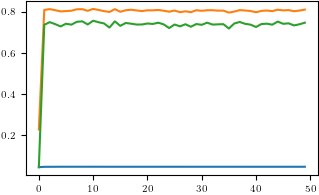

In [1]:
import pystan
import pandas as pd
import numpy as np
import requests

from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
import rpy2.robjects as ro
import json
import jax

from scipy.special import logsumexp

from amis_algorithms import alpha_AMIS_fixed_dof, AMIS_student_fixed_dof
import multiprocessing
multiprocessing.set_start_method("fork")

import bridgestan

from utils import old_ksd

import matplotlib.pyplot as plt
from tueplots import bundles
plt.rcParams.update(bundles.aistats2023())


# Load and prepare the dataset
url = "https://github.com/faosorios/heavy/blob/master/data/creatinine.rda?raw=true"
with requests.get(url) as resp:
    with open("creatinine.rda", "wb") as f:
        f.write(resp.content)

# Load RDA file into Python
ro.r['load']("creatinine.rda")
df = pandas2ri.rpy2py_dataframe(ro.r['creatinine'])

data_df = pd.DataFrame(columns=['log_SC', 'log_WT', 'log_140_minus_A', 'log_CR'])

# Apply transformations following https://openreview.net/pdf?id=HltJfwwfhX
data_df['log_SC'] = np.log(df['SC'])
data_df['log_WT'] = np.log(df['WT'])
data_df['log_CR'] = np.log(df['CR'])
data_df['log_140_minus_A'] = np.log(140 - df['Age'])
data_df = data_df.dropna() # remove any rows with NaN values after transformation

# Compile the Stan model
sm = pystan.StanModel(file="./student_reg_model.stan")

# Prepare data for Stan model
data_for_stan = {
    'N': len(data_df),
    'x1': data_df['log_SC'].values.tolist(),
    'x2': data_df['log_WT'].values.tolist(),
    'x3': data_df['log_140_minus_A'].values.tolist(),
    'y': data_df['log_CR'].values.tolist()  # response variable
}

# Save the data dictionary to a JSON file
with open("student_regression_data.json", "w") as f:
    json.dump(data_for_stan, f, indent=4)


# Fit the model and sample from the posterior using NUTS (NUTS paper: https://arxiv.org/abs/1111.4246)
fit = sm.sampling(data=data_for_stan, iter=1000, warmup=200, chains=3)
mcmc_samples = fit.extract()

stan = "./student_reg_model.stan"
data = "./student_regression_data.json"
bridgestan_model = bridgestan.StanModel.from_stan_file(stan, data)

true_log_pdf = fit.log_prob

# Step 3: Find the MAP solution
map_sol = sm.optimizing(data=data_for_stan)

# Retrieve the values, extract the single element from each array, and convert to an ndarray
map_sol_array = np.array([value.item() for value in map_sol.values()])

map_sol_list = list(map_sol.values())
log_dens_at_map, _, hessian_at_map = bridgestan_model.log_density_hessian(theta_unc=map_sol_array, propto=True)

assert np.isclose(log_dens_at_map, fit.log_prob(map_sol_list))

# Negative inverse of the Hessian at the MAP solution used as covariance
cov = -np.linalg.inv(hessian_at_map)
assert np.all(np.linalg.eigvals(cov) > 0)

dim = 4
dof_proposal = 3
mu_initial_proposal = map_sol_array
shape_initial_proposal = (dof_proposal - 2) / (dof_proposal) * cov
num_samples = 10000
alpha = 1 + 2 / (dof_proposal + dim)

all_estimate_Z, all_alphaESS, all_ESS, adapted_proposal = alpha_AMIS_fixed_dof(mu_initial=mu_initial_proposal,shape_initial=shape_initial_proposal, n_iterations=50, log_pi_tilde=true_log_pdf, dof_proposal=dof_proposal, M=num_samples, D=dim)

plt.plot(all_estimate_Z)
plt.plot(all_alphaESS)
plt.plot(all_ESS)

from collections import OrderedDict
# Last key is the log probability, which we don't want
exclude_key = "lp__"
print(mcmc_samples.keys())
mcmc_samples = OrderedDict((k, v) for k, v in mcmc_samples.items() if k != exclude_key)

mcmc_samples_array = np.vstack(list(mcmc_samples.values())).T



In [2]:
# def numpy_callback(x):
#   # Need to forward-declare the shape & dtype of the expected output.
#   result_shape = jax.core.ShapedArray(x.shape, x.dtype)
#   return jax.pure_callback(np.sin, result_shape, x)

def log_density_gradient_correct(theta):
    return bridgestan_model.log_density_gradient(theta)[1]

def log_density_gradient(theta):
    result_shape = jax.core.ShapedArray(theta.shape , theta.dtype)
    # _, gradient = bridgestan_model.log_density_gradient(theta)
    gradient = jax.experimental.io_callback(log_density_gradient_correct, result_shape, theta)
    return gradient

In [3]:
print(mcmc_samples_array.shape)

(2400, 4)


In [4]:
map_sol_array.shape

(4,)

In [5]:
jax.config.update("jax_enable_x64", True)
# compare results with MCMC via the KSD
ksd_mcmc_samples = old_ksd(mcmc_samples_array, log_density_gradient)
print("KSD using true samples:", ksd_mcmc_samples)



INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


KSD using true samples: 0.007780915929109829


In [6]:
from scipy.special import logsumexp

final_samples = adapted_proposal.rvs(size=10000)

weights = bridgestan_model.log_density(final_samples) - adapted_proposal.logpdf(final_samples)
normalized_weights = np.exp(weights - logsumexp(weights))
ksd_fixed_dof = old_ksd(final_samples, log_density_gradient, weights=normalized_weights)
print("KSD for adapted proposal samples:", ksd_fixed_dof)


KSD for adapted proposal samples: 0.22131439817436832
